<a href="https://colab.research.google.com/github/DannyCollinson/EMIT-ECOSTRESS/blob/Autoencoder/EEAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory notebook

In [2]:
!pip install netCDF4
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 16.6 MB/s eta 0:00:00


In [6]:
import os

from tifffile import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from netCDF4 import Dataset as ncDataset
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [4]:
# Initialize RNG
rng = np.random.default_rng()

# Check if running with GPU runtime
torch.cuda.is_available()

True

## Pull latest from git repos

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
os.chdir('/content/drive/Shareddrives/emit-ecostress/EMIT-ECOSTRESS')
!git pull https://github.com/DannyCollinson/EMIT-ECOSTRESS.git

From https://github.com/DannyCollinson/EMIT-ECOSTRESS
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [11]:
os.chdir('/content/drive/Shareddrives/emit-ecostress/VITALS')
!git pull https://github.com/DannyCollinson/VITALS.git

From https://github.com/DannyCollinson/VITALS
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


## Load and explore ECOSTRESS average LST data LA day/night summer 2018-2021

In [7]:
im_day = tifffile.imread('/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/ECOSTRESS_LA_daytime_summer_LST_2018_2021.tif')
im_night = tifffile.imread('/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/ECOSTRESS_LA_nighttime_summer_LST_2018_2021.tif')

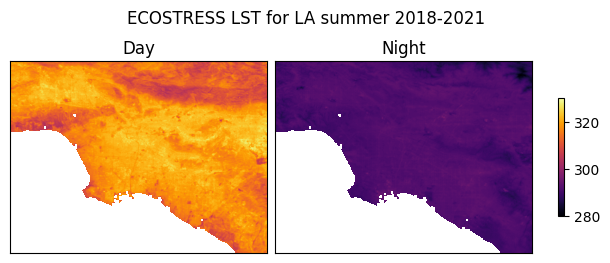

In [8]:
fig, axs = plt.subplots(1, 2, layout='constrained', figsize=(6, 2.75))
fig.suptitle('ECOSTRESS LST for LA summer 2018-2021')
axs[0].title.set_text('Day')
axs[1].title.set_text('Night')
normalizer = Normalize(
    min(np.nanmin(im_day), np.nanmin(im_night)),
    max(np.nanmax(im_day), np.nanmax(im_night)),
)
axs[0].imshow(im_day, norm=normalizer, cmap='inferno')
axs[1].imshow(im_night, norm=normalizer, cmap='inferno')
axs[0].set_xticks([],[])
axs[1].set_xticks([],[])
axs[0].set_yticks([],[])
axs[1].set_yticks([],[])
fig.colorbar(
    ScalarMappable(normalizer, 'inferno'), ax=axs, shrink=0.5, fraction=0.5
)
plt.show(fig)

In [9]:
day_vals = im_day[~np.isnan(im_day)]
night_vals = im_night[~np.isnan(im_night)]

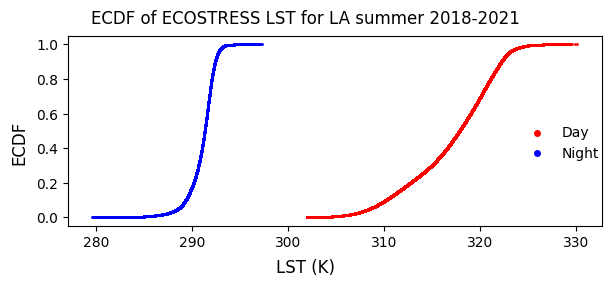

In [10]:
fig, ax = plt.subplots(layout='constrained', figsize=(6, 2.75))
fig.suptitle('ECDF of ECOSTRESS LST for LA summer 2018-2021')
fig.supylabel('ECDF')
fig.supxlabel('LST (K)')
ax.scatter(
    np.sort(day_vals),
    np.arange(1, len(day_vals) + 1) / len(day_vals),
    s=1,
    c='r',
    label='Day'
)
ax.scatter(
    np.sort(night_vals),
    np.arange(1, len(night_vals) + 1) / len(night_vals),
    s=1,
    c='b',
    label='Night'
)
fig.legend(loc='right', markerscale=4, frameon=False)
plt.show()

## Load and explore EMIT data 2023-07-28

In [12]:
# emit_002 = ncDataset('/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/EMIT_L2A_RFL_001_20230728T214106_2320914_002.nc')
emit_003 = ncDataset('/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/EMIT_L2A_RFL_001_20230728T214118_2320914_003.nc')
for key in vars(emit_003).keys():
    continue
    print(key)
    # print(vars(emit_002)[key])
    print(vars(emit_003)[key], end='\n\n')

In [13]:
# emit_002_data = emit_002.variables['reflectance'][:,:,:]
emit_003_data = emit_003.variables['reflectance'][:,:,:]
np.sum(emit_003_data.mask)# , np.sum(emit_002_data.mask)

0

#### Visualize spectra

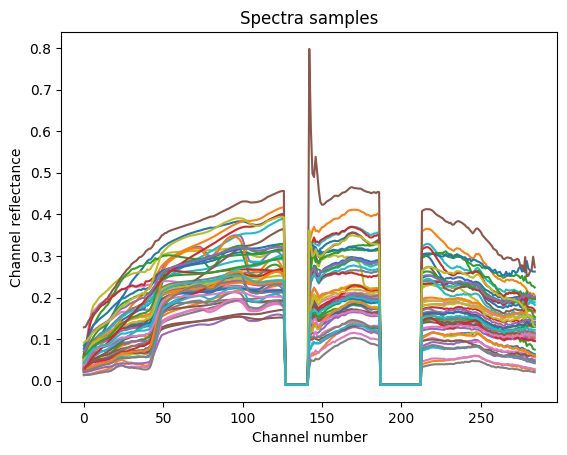

In [13]:
fig, ax = plt.subplots()
ax.title.set_text('Spectra samples')
ax.set_xlabel('Channel number')
ax.set_ylabel('Channel reflectance')
num_spectra = 50
for i, j in zip(
    rng.choice(np.arange(emit_003_data.shape[0]), size=num_spectra),
    rng.choice(np.arange(emit_003_data.shape[1]), size=num_spectra),
):
    ax.plot(
        np.arange(len(emit_003_data[i,j,:].data)),
        emit_003_data[i,j,:].data,
    )
plt.show(fig)

#### Visualize value distribution

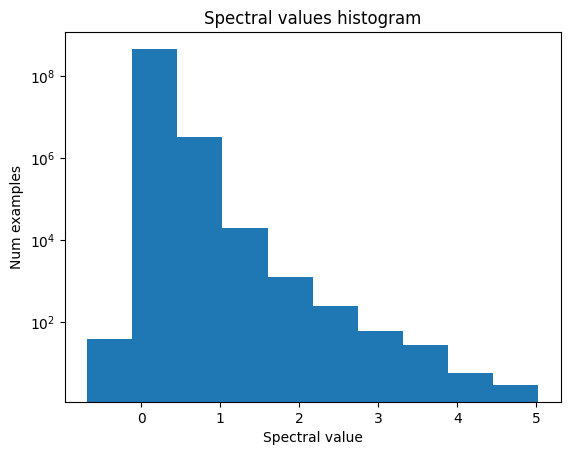

In [14]:
fig, ax = plt.subplots()
ax.title.set_text('Spectral values histogram')
ax.set_xlabel('Spectral value')
ax.set_ylabel('Num examples')
ax.hist(emit_003_data[:, :, :].flatten(), log=True)
plt.show(fig)

#### Clean EMIT data and revisualize
We want to clip values to the range [0,1] and remove the channels that are always 0.

In [15]:
emit_003_data = np.clip(emit_003_data, 0, 1)
emit_003_data = emit_003_data[:, :, np.sum(emit_003_data, axis=(0,1)) != 0]

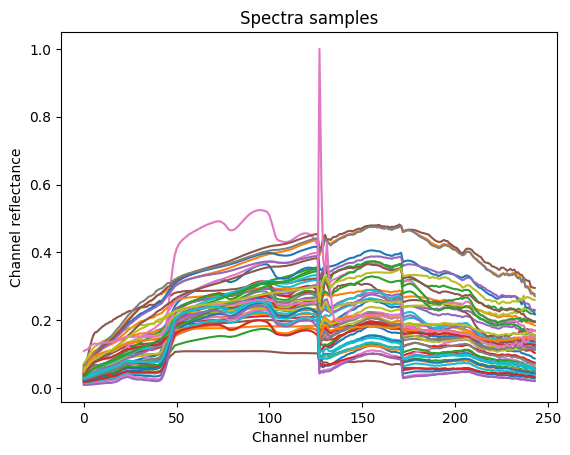

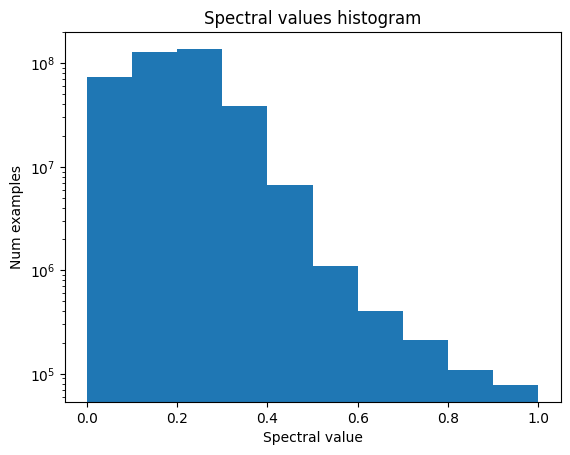

In [16]:
fig, ax = plt.subplots()
ax.title.set_text('Spectra samples')
ax.set_xlabel('Channel number')
ax.set_ylabel('Channel reflectance')
num_spectra = 50
for i, j in zip(
    rng.choice(np.arange(emit_003_data.shape[0]), size=num_spectra),
    rng.choice(np.arange(emit_003_data.shape[1]), size=num_spectra),
):
    ax.plot(
        np.arange(len(emit_003_data[i,j,:].data)),
        emit_003_data[i,j,:].data,
    )
plt.show(fig)

fig, ax = plt.subplots()
ax.title.set_text('Spectral values histogram')
ax.set_xlabel('Spectral value')
ax.set_ylabel('Num examples')
ax.hist(emit_003_data[:, :, :].flatten(), log=True)
plt.show(fig)

## PCA on spectra

#### Standard PCA

In [17]:
pca = PCA(n_components=0.9999)
pca_spectra = pca.fit_transform(
    emit_003_data.reshape(
        emit_003_data.shape[0] * emit_003_data.shape[1],
        emit_003_data.shape[2],
    )
)
pca_spectra = pca_spectra.reshape(
    emit_003_data.shape[0],
    emit_003_data.shape[1],
    pca_spectra.shape[1],
)

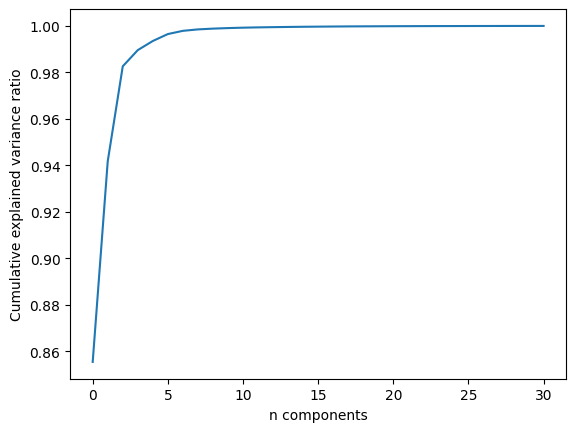

[0.8553722213883312,
 0.9416675100341239,
 0.9825310741670326,
 0.9895021066198121,
 0.9934228653697285,
 0.9964023011054659,
 0.997789208307897,
 0.9984080356643232,
 0.9987390812404222,
 0.9989713220701035]

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel('n components')
ax.set_ylabel('Cumulative explained variance ratio')
ax.plot(np.arange(len(pca.explained_variance_ratio_)), [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1,len(pca.explained_variance_ratio_) + 1)])
plt.show(fig)
[np.sum(pca.explained_variance_ratio_[:i]) for i in range(1,len(pca.explained_variance_ratio_) + 1)][:10]

Autoencoder on 003 Spectra

In [24]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

input_dim = 285 # incorrect should be 244
encoding_dim = 31
model = Autoencoder(input_dim, encoding_dim)

device = torch.device("cuda:0")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

data_loader = DataLoader(emit_003_data, batch_size=10, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    for batch in data_loader:
        optimizer.zero_grad()

        batch = batch.to(device)

        output = model(batch)
        loss = criterion(output, batch)

        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

torch.save(model.state_dict(), 'autoencoder.pth')

model.load_state_dict(torch.load('autoencoder.pth'))
model.to(device)

with torch.no_grad():
    reconstructed_data = model(emit_003_data, device="????")

with torch.no_grad():
    latent_representation = model.encoder(emit_003_data, device=device)

Epoch [1/10], Loss: 0.01222873292863369
Epoch [2/10], Loss: 0.010284936986863613
Epoch [3/10], Loss: 0.010028285905718803
Epoch [4/10], Loss: 0.007752600591629744
Epoch [5/10], Loss: 0.006375151686370373
Epoch [6/10], Loss: 0.004226925782859325
Epoch [7/10], Loss: 0.0026289159432053566
Epoch [8/10], Loss: 0.0017464827978983521
Epoch [9/10], Loss: 0.000867859460413456
Epoch [10/10], Loss: 0.0006152301793918014


TypeError: ignored

In [25]:
# functional but does not use cuda

# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, encoding_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, input_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# input_dim = 244
# encoding_dim = 31
# model = Autoencoder(input_dim, encoding_dim)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# data_loader = DataLoader(emit_003_data, batch_size=16, shuffle=True)

# # emit_003_data_transposed = emit_003_data.T

# num_epochs = 10

# for epoch in range(num_epochs):
#     for batch in data_loader:
#         optimizer.zero_grad()

#         output = model(batch)
#         loss = criterion(output, batch)

#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


RuntimeError: ignored

In [24]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=244, out_features=256, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=244, bias=True)
    (1): Sigmoid()
  )
)